<a href="https://colab.research.google.com/github/dennislysenko/bloodhound-radio/blob/master/CoverGen_No_UI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://github.com/ardha27/AICoverGen-NoUI-Colab

In [4]:
#@title Clone repository
!git clone https://github.com/SociallyIneptWeeb/AICoverGen.git
%cd AICoverGen

Cloning into 'AICoverGen'...
remote: Enumerating objects: 375, done.
remote: Counting objects: 100% (212/212), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 375 (delta 141), reused 138 (delta 138), pack-reused 163 (from 1)
Receiving objects: 100% (375/375), 1.81 MiB | 26.80 MiB/s, done.
Resolving deltas: 100% (236/236), done.
/content/AICoverGen


In [27]:
#@title Install Python 3.9
!apt-get update
!apt-get install python3.9 python3.9-distutils
!update-alternatives --install /usr/local/bin/python3 python3 /usr/bin/python3.9 1
!update-alternatives --config python3
!python3 --version


Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading

In [19]:
%%writefile requirements.txt
deemix
fairseq==0.12.2
faiss-cpu==1.7.3
ffmpeg-python>=0.2.0
gradio==3.39.0
lib==4.0.0
librosa==0.9.1
numpy==1.23.5
onnxruntime
praat-parselmouth>=0.4.2
pedalboard==0.7.7
pydub==0.25.1
pyworld==0.3.4
Requests==2.31.0
scipy==1.11.1
soundfile==0.12.1
--find-links https://download.pytorch.org/whl/torch_stable.html
torch==2.0.1+cu118
torchcrepe==0.0.20
tqdm==4.65.0
yt_dlp==2023.7.6
sox==1.4.1

Overwriting requirements.txt


In [32]:
#@title Install requirements
# Reinstall pip for Python 3.9
# !curl -sS https://bootstrap.pypa.io/get-pip.py | python3
# !python3.9 -m pip install "pip<24.1"
!cat requirements.txt
!python3.9 -m pip install torch==2.0.1+cu118 -f https://download.pytorch.org/whl/torch_stable.html --no-deps

# Install system dependencies
!apt-get update
!apt-get install -y build-essential python3.9-dev libasound2-dev portaudio19-dev libportaudio2 libportaudiocpp0 ffmpeg

# Install fairseq and pyworld separately first
!python3.9 -m pip install fairseq==0.12.2 --no-deps
!python3.9 -m pip install pyworld==0.3.4 --no-deps

!python3.9 -m pip install -r requirements.txt --no-deps
!sudo apt update
!sudo apt install sox

deemix
fairseq==0.12.2
faiss-cpu==1.7.3
ffmpeg-python>=0.2.0
gradio==3.39.0
lib==4.0.0
librosa==0.9.1
numpy==1.23.5
onnxruntime
praat-parselmouth>=0.4.2
pedalboard==0.7.7
pydub==0.25.1
pyworld==0.3.4
Requests==2.31.0
scipy==1.11.1
soundfile==0.12.1
--find-links https://download.pytorch.org/whl/torch_stable.html
torch==2.0.1+cu118
torchcrepe==0.0.20
tqdm==4.65.0
yt_dlp==2023.7.6
sox==1.4.1
Looking in links: https://download.pytorch.org/whl/torch_stable.html
Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jamm

In [35]:
#@title Test Python Package installs
import sys
print(f"Python version: {sys.version}")


import gradio
import numpy

print("Hi!")

Python version: 3.11.12 (main, Apr  9 2025, 08:55:54) [GCC 11.4.0]
Hi!


In [6]:
#@title Download MDXNet Vocal Separation and Hubert Base Models
!python src/download_models.py

All models downloaded!


In [7]:
#@title Model Download Function

import os
import zipfile
import shutil
import urllib.request

BASE_DIR = os.getcwd()
rvc_models_dir = os.path.join(BASE_DIR, 'rvc_models')

def extract_zip(extraction_folder, zip_name):
    os.makedirs(extraction_folder)
    with zipfile.ZipFile(zip_name, 'r') as zip_ref:
        zip_ref.extractall(extraction_folder)
    os.remove(zip_name)

    index_filepath, model_filepath = None, None
    for root, dirs, files in os.walk(extraction_folder):
        for name in files:
            if name.endswith('.index') and os.stat(os.path.join(root, name)).st_size > 1024 * 100:
                index_filepath = os.path.join(root, name)

            if name.endswith('.pth') and os.stat(os.path.join(root, name)).st_size > 1024 * 1024 * 40:
                model_filepath = os.path.join(root, name)

    if not model_filepath:
        raise Exception(f'No .pth model file was found in the extracted zip. Please check {extraction_folder}.')

    # move model and index file to extraction folder
    os.rename(model_filepath, os.path.join(extraction_folder, os.path.basename(model_filepath)))
    if index_filepath:
        os.rename(index_filepath, os.path.join(extraction_folder, os.path.basename(index_filepath)))

    # remove any unnecessary nested folders
    for filepath in os.listdir(extraction_folder):
        if os.path.isdir(os.path.join(extraction_folder, filepath)):
            shutil.rmtree(os.path.join(extraction_folder, filepath))

def download_online_model(url, dir_name):
    try:
        print(f'[~] Downloading voice model with name {dir_name}...')
        zip_name = url.split('/')[-1]
        extraction_folder = os.path.join(rvc_models_dir, dir_name)
        if os.path.exists(extraction_folder):
            raise Exception(f'Voice model directory {dir_name} already exists! Choose a different name for your voice model.')

        if 'pixeldrain.com' in url:
            url = f'https://pixeldrain.com/api/file/{zip_name}'

        urllib.request.urlretrieve(url, zip_name)

        print('[~] Extracting zip...')
        extract_zip(extraction_folder, zip_name)
        print(f'[+] {dir_name} Model successfully downloaded!')

    except Exception as e:
        raise Exception(str(e))

url = "https://pixeldrain.com/u/3tJmABXA" # @param {type:"string"}
dir_name = "Gura" # @param {type:"string"}

download_online_model(url, dir_name)

[~] Downloading voice model with name Gura...
[~] Extracting zip...
[+] Gura Model successfully downloaded!


In [5]:
!pwd
!ls -l

/content/AICoverGen
total 68
-rw-r--r-- 1 root root  3894 Apr 23 16:28 AICoverGen_colab.ipynb
-rw-r--r-- 1 root root  1290 Apr 23 16:28 cog.yaml
drwxr-xr-x 2 root root  4096 Apr 23 16:28 images
-rw-r--r-- 1 root root  1074 Apr 23 16:28 LICENSE
drwxr-xr-x 2 root root  4096 Apr 23 16:28 mdxnet_models
-rw-r--r-- 1 root root 12601 Apr 23 16:28 predict.py
-rw-r--r-- 1 root root 12744 Apr 23 16:28 README.md
-rw-r--r-- 1 root root   396 Apr 23 16:28 requirements.txt
drwxr-xr-x 2 root root  4096 Apr 23 16:28 rvc_models
drwxr-xr-x 2 root root  4096 Apr 23 16:28 song_output
drwxr-xr-x 4 root root  4096 Apr 23 16:28 src


In [36]:
# @title Generate | Output generated inside "AICoverGen\song_output\random_number"
# @markdown Main Option | You also can input audio path inside "SONG_INPUT"
SONG_INPUT = "https://www.youtube.com/watch?v=jgCVkQhlScc&pp=ygUFY3VwaWQ%3D" # @param {type:"string"}
RVC_DIRNAME = "Gura" # @param {type:"string"}
PITCH_CHANGE = 0 # @param {type:"integer"}
PITCH_CHANGE_ALL = 0 # @param {type:"integer"}
# @markdown Voice Conversion Options
INDEX_RATE = 0.5 # @param {type:"number"}
FILTER_RADIUS = 3 # @param {type:"integer"}
PITCH_DETECTION_ALGO = "rmvpe" # @param ["rmvpe", "mangio-crepe"]
CREPE_HOP_LENGTH = 128 # @param {type:"integer"}
PROTECT = 0.33 # @param {type:"number"}
REMIX_MIX_RATE = 0.25  # @param {type:"number"}
# @markdown Audio Mixing Options
MAIN_VOL = 0 # @param {type:"integer"}
BACKUP_VOL = 0 # @param {type:"integer"}
INST_VOL = 0 # @param {type:"integer"}
# @markdown Reverb Control
REVERB_SIZE = 0.15 # @param {type:"number"}
REVERB_WETNESS = 0.2 # @param {type:"number"}
REVERB_DRYNESS = 0.8 # @param {type:"number"}
REVERB_DAMPING = 0.7 # @param {type:"number"}
# @markdown Output Format
OUTPUT_FORMAT = "mp3" # @param ["mp3", "wav"]

import subprocess

command = [
    "python3.9",
    "src/main.py",
    "-i", SONG_INPUT,
    "-dir", RVC_DIRNAME,
    "-p", str(PITCH_CHANGE),
    "-k",
    "-ir", str(INDEX_RATE),
    "-fr", str(FILTER_RADIUS),
    "-rms", str(REMIX_MIX_RATE),
    "-palgo", PITCH_DETECTION_ALGO,
    "-hop", str(CREPE_HOP_LENGTH),
    "-pro", str(PROTECT),
    "-mv", str(MAIN_VOL),
    "-bv", str(BACKUP_VOL),
    "-iv", str(INST_VOL),
    "-pall", str(PITCH_CHANGE_ALL),
    "-rsize", str(REVERB_SIZE),
    "-rwet", str(REVERB_WETNESS),
    "-rdry", str(REVERB_DRYNESS),
    "-rdamp", str(REVERB_DAMPING),
    "-oformat", OUTPUT_FORMAT
]

# Open a subprocess and capture its output
process = subprocess.Popen(command, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, universal_newlines=True)

# Print the output in real-time
for line in process.stdout:
    print(line, end='')

# Wait for the process to finish
process.wait()

Traceback (most recent call last):
  File "/content/AICoverGen/src/main.py", line 11, in <module>
    import gradio as gr
  File "/usr/local/lib/python3.9/dist-packages/gradio/__init__.py", line 3, in <module>
    import gradio.components as components
  File "/usr/local/lib/python3.9/dist-packages/gradio/components/__init__.py", line 1, in <module>
    from gradio.components.annotated_image import AnnotatedImage
  File "/usr/local/lib/python3.9/dist-packages/gradio/components/annotated_image.py", line 8, in <module>
    from gradio_client.documentation import document, set_documentation_group
ModuleNotFoundError: No module named 'gradio_client'


1

Example of generated audio path

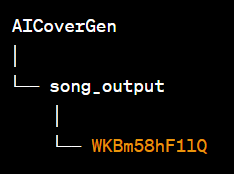